# импорты

In [1]:
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

In [3]:
session = boto3.session.Session()

In [4]:
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id='YCAJErlaldUmioGbHQSqJ70MR',
    aws_secret_access_key='YCPSba_JgloNYSNWcnKO2CYCEB8PFR1Iwgr2jIUy',
    region_name='ru-cental1'
)

In [5]:
BUCKET_NAME = "mlds23-authorship-identification"

## загружаем все тексты сразу

In [64]:
text_lst = []
target_lst = []
book_lst = []
for key in s3.list_objects(Bucket=BUCKET_NAME)['Contents']:
    try:
        if 'txt' in key['Key']: #фильтруем по расширению файла, нужны только txt
            file = s3.get_object(Bucket=BUCKET_NAME,Key=key['Key'])['Body']
            text = file.read().decode("utf-8")
            text_lst.append(text[12:])
            target_lst.append(text[:12])
            book_lst.append(key['Key']) #добавляем название произведения в отдельный столбец
    except:
        print('не тот файл', key['Key'])
        continue

df = pd.DataFrame(columns=["target", "text", 'book'])
df['text'] = pd.Series(text_lst)
df['target'] = pd.Series(target_lst)
df['book'] = pd.Series(book_lst)

In [65]:
df.head()

,target,text,book
0,author_id_06,"Узкими горными тропинками, от одного дачного п...",raw_data/aleksandr_kuprin_belyj_pudel'.txt
1,author_id_06,Александр КупринСледующий рассказ не есть плод...,raw_data/aleksandr_kuprin_chudesnyj_doktor.txt
2,author_id_06,Александр КупринТак называлась пивная в бойком...,raw_data/aleksandr_kuprin_gambrinus.txt
3,author_id_06,Александр КупринL. van Beethoven. 2 Son. (op. ...,raw_data/aleksandr_kuprin_granatovyj_braslet.txt
4,author_id_06,Александр КупринПосвящаю памяти несравненного ...,raw_data/aleksandr_kuprin_izumrud.txt


# EDA

In [33]:
df['Length'] = df['text'].str.len()
df.head(10)

,target,text,book,Length
0,author_id_06,"Узкими горными тропинками, от одного дачного п...",raw_data/aleksandr_kuprin_belyj_pudel'.txt,60585
1,author_id_06,Александр КупринСледующий рассказ не есть плод...,raw_data/aleksandr_kuprin_chudesnyj_doktor.txt,16508
2,author_id_06,Александр КупринТак называлась пивная в бойком...,raw_data/aleksandr_kuprin_gambrinus.txt,47575
3,author_id_06,Александр КупринL. van Beethoven. 2 Son. (op. ...,raw_data/aleksandr_kuprin_granatovyj_braslet.txt,91170
4,author_id_06,Александр КупринПосвящаю памяти несравненного ...,raw_data/aleksandr_kuprin_izumrud.txt,31257
5,author_id_06,"Николай Евграфович Алмазов едва дождался, пока...",raw_data/aleksandr_kuprin_kust_sireni.txt,10492
6,author_id_06,Александр КупринЗаводский гудок протяжно ревел...,raw_data/aleksandr_kuprin_moloh.txt,152842
7,author_id_06,"Александр КупринМой милый, сердитый друг! Я по...",raw_data/aleksandr_kuprin_osennie_tsvety.txt,18801
8,author_id_06,"Александр КупринПоложи мя, яко печать, на серд...",raw_data/aleksandr_kuprin_sulamif'.txt,102431
9,author_id_06,Александр КупринДвенадцатилетняя Тиночка Рудне...,raw_data/aleksandr_kuprin_taper.txt,24808


In [34]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [35]:
df['Word_count'] = df['text'].apply(word_count)
df.head(10)

,target,text,book,Length,Word_count
0,author_id_06,"Узкими горными тропинками, от одного дачного п...",raw_data/aleksandr_kuprin_belyj_pudel'.txt,60585,9215
1,author_id_06,Александр КупринСледующий рассказ не есть плод...,raw_data/aleksandr_kuprin_chudesnyj_doktor.txt,16508,2427
2,author_id_06,Александр КупринТак называлась пивная в бойком...,raw_data/aleksandr_kuprin_gambrinus.txt,47575,6953
3,author_id_06,Александр КупринL. van Beethoven. 2 Son. (op. ...,raw_data/aleksandr_kuprin_granatovyj_braslet.txt,91170,14085
4,author_id_06,Александр КупринПосвящаю памяти несравненного ...,raw_data/aleksandr_kuprin_izumrud.txt,31257,4684
5,author_id_06,"Николай Евграфович Алмазов едва дождался, пока...",raw_data/aleksandr_kuprin_kust_sireni.txt,10492,1622
6,author_id_06,Александр КупринЗаводский гудок протяжно ревел...,raw_data/aleksandr_kuprin_moloh.txt,152842,22602
7,author_id_06,"Александр КупринМой милый, сердитый друг! Я по...",raw_data/aleksandr_kuprin_osennie_tsvety.txt,18801,2877
8,author_id_06,"Александр КупринПоложи мя, яко печать, на серд...",raw_data/aleksandr_kuprin_sulamif'.txt,102431,15917
9,author_id_06,Александр КупринДвенадцатилетняя Тиночка Рудне...,raw_data/aleksandr_kuprin_taper.txt,24808,3630


In [39]:
df['mean_word_length'] = df['text'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
df.head(10)

,target,text,book,Length,Word_count,mean_word_length
0,author_id_06,"Узкими горными тропинками, от одного дачного п...",raw_data/aleksandr_kuprin_belyj_pudel'.txt,60585,9215,5.574715
1,author_id_06,Александр КупринСледующий рассказ не есть плод...,raw_data/aleksandr_kuprin_chudesnyj_doktor.txt,16508,2427,5.802225
2,author_id_06,Александр КупринТак называлась пивная в бойком...,raw_data/aleksandr_kuprin_gambrinus.txt,47575,6953,5.840357
3,author_id_06,Александр КупринL. van Beethoven. 2 Son. (op. ...,raw_data/aleksandr_kuprin_granatovyj_braslet.txt,91170,14085,5.472914
4,author_id_06,Александр КупринПосвящаю памяти несравненного ...,raw_data/aleksandr_kuprin_izumrud.txt,31257,4684,5.672929
5,author_id_06,"Николай Евграфович Алмазов едва дождался, пока...",raw_data/aleksandr_kuprin_kust_sireni.txt,10492,1622,5.469174
6,author_id_06,Александр КупринЗаводский гудок протяжно ревел...,raw_data/aleksandr_kuprin_moloh.txt,152842,22602,5.762233
7,author_id_06,"Александр КупринМой милый, сердитый друг! Я по...",raw_data/aleksandr_kuprin_osennie_tsvety.txt,18801,2877,5.535280
8,author_id_06,"Александр КупринПоложи мя, яко печать, на серд...",raw_data/aleksandr_kuprin_sulamif'.txt,102431,15917,5.435384
9,author_id_06,Александр КупринДвенадцатилетняя Тиночка Рудне...,raw_data/aleksandr_kuprin_taper.txt,24808,3630,5.834435


In [42]:
df['mean_sent_length'] = df['text'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
df.head(10)

,target,text,book,Length,Word_count,mean_word_length,mean_sent_length
0,author_id_06,"Узкими горными тропинками, от одного дачного п...",raw_data/aleksandr_kuprin_belyj_pudel'.txt,60585,9215,5.574715,86.678726
1,author_id_06,Александр КупринСледующий рассказ не есть плод...,raw_data/aleksandr_kuprin_chudesnyj_doktor.txt,16508,2427,5.802225,133.219512
2,author_id_06,Александр КупринТак называлась пивная в бойком...,raw_data/aleksandr_kuprin_gambrinus.txt,47575,6953,5.840357,149.085174
3,author_id_06,Александр КупринL. van Beethoven. 2 Son. (op. ...,raw_data/aleksandr_kuprin_granatovyj_braslet.txt,91170,14085,5.472914,108.450180
4,author_id_06,Александр КупринПосвящаю памяти несравненного ...,raw_data/aleksandr_kuprin_izumrud.txt,31257,4684,5.672929,143.036866
5,author_id_06,"Николай Евграфович Алмазов едва дождался, пока...",raw_data/aleksandr_kuprin_kust_sireni.txt,10492,1622,5.469174,110.627660
6,author_id_06,Александр КупринЗаводский гудок протяжно ревел...,raw_data/aleksandr_kuprin_moloh.txt,152842,22602,5.762233,129.641026
7,author_id_06,"Александр КупринМой милый, сердитый друг! Я по...",raw_data/aleksandr_kuprin_osennie_tsvety.txt,18801,2877,5.535280,168.387387
8,author_id_06,"Александр КупринПоложи мя, яко печать, на серд...",raw_data/aleksandr_kuprin_sulamif'.txt,102431,15917,5.435384,152.342814
9,author_id_06,Александр КупринДвенадцатилетняя Тиночка Рудне...,raw_data/aleksandr_kuprin_taper.txt,24808,3630,5.834435,156.037975


In [54]:
def visualize(col):
    
    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=df[col], hue=df['target'])
    plt.ylabel(col, labelpad=12.5)
    
    # plt.subplot(1,2,2)
    # sns.kdeplot(df[col], hue=df['target'])
    plt.legend(df['target'].unique())
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()

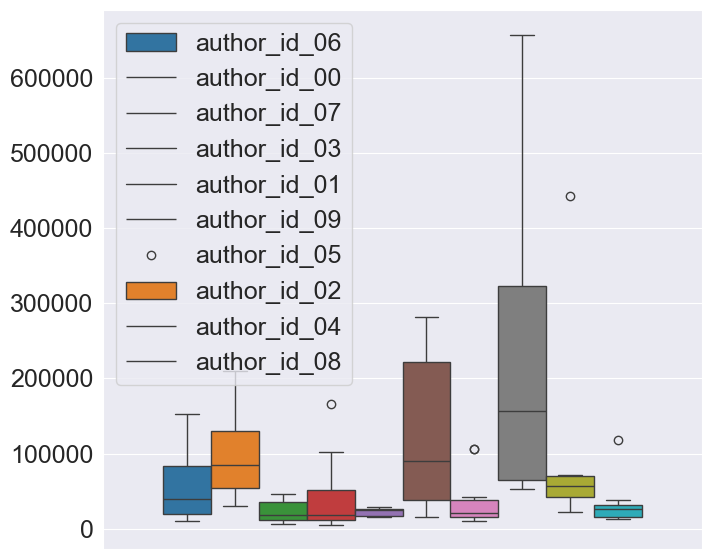

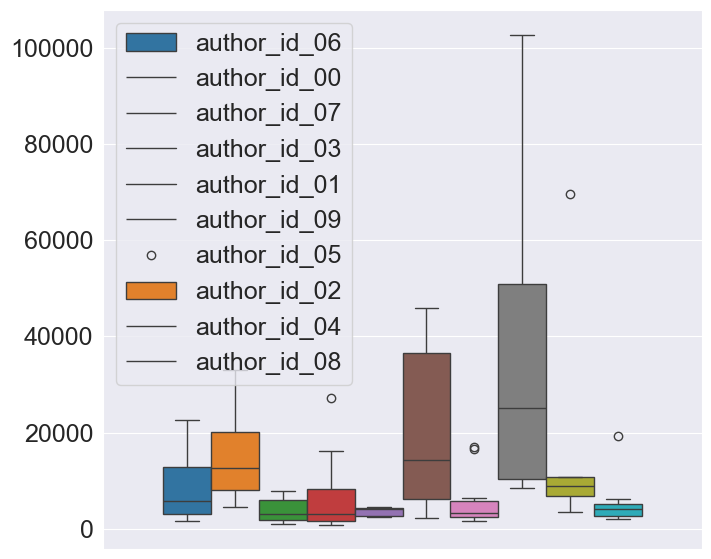

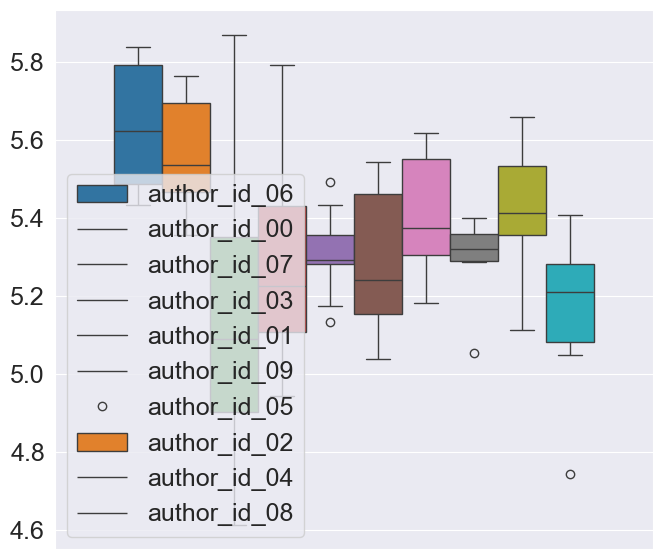

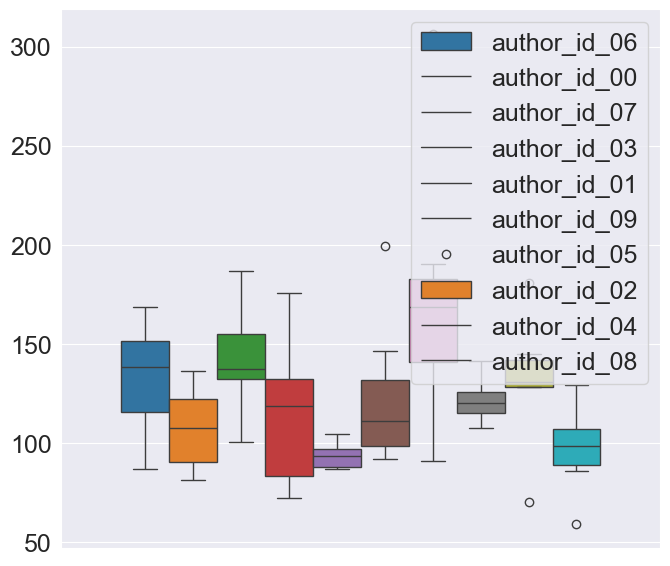

In [56]:
features = df.columns.tolist()[3:]
for feature in features:
    visualize(feature)

# Term Frequency Analysis

In [67]:
df = df.drop(features, axis=1)
df.head()

,target,text,book
0,author_id_06,"Узкими горными тропинками, от одного дачного п...",raw_data/aleksandr_kuprin_belyj_pudel'.txt
1,author_id_06,Александр КупринСледующий рассказ не есть плод...,raw_data/aleksandr_kuprin_chudesnyj_doktor.txt
2,author_id_06,Александр КупринТак называлась пивная в бойком...,raw_data/aleksandr_kuprin_gambrinus.txt
3,author_id_06,Александр КупринL. van Beethoven. 2 Son. (op. ...,raw_data/aleksandr_kuprin_granatovyj_braslet.txt
4,author_id_06,Александр КупринПосвящаю памяти несравненного ...,raw_data/aleksandr_kuprin_izumrud.txt


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  88 non-null     object
 1   text    88 non-null     object
 2   book    88 non-null     object
dtypes: object(3)
memory usage: 2.2+ KB


In [75]:
def clean(review):
    
    review = review.lower()
    review = re.sub('[^а-я А-я 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('russian')])
    
    return review

In [76]:
df['text'] = df['text'].apply(clean)
df.head(10)

,target,text,book,text_lists
0,author_id_06,узкими горными тропинками одного дачного посел...,raw_data/aleksandr_kuprin_belyj_pudel'.txt,"[узкими, горными, тропинками, от, одного, дачн..."
1,author_id_06,александр купринследующий рассказ плод досужег...,raw_data/aleksandr_kuprin_chudesnyj_doktor.txt,"[александр, купринследующий, рассказ, не, есть..."
2,author_id_06,александр купринтак называлась пивная бойком п...,raw_data/aleksandr_kuprin_gambrinus.txt,"[александр, купринтак, называлась, пивная, в, ..."
3,author_id_06,александр куприн 2 2 2 середине августа рожден...,raw_data/aleksandr_kuprin_granatovyj_braslet.txt,"[александр, куприн, 2, 2, 2, в, середине, авгу..."
4,author_id_06,александр купринпосвящаю памяти несравненного ...,raw_data/aleksandr_kuprin_izumrud.txt,"[александр, купринпосвящаю, памяти, несравненн..."
5,author_id_06,николай евграфович алмазов едва дождался пока ...,raw_data/aleksandr_kuprin_kust_sireni.txt,"[николай, евграфович, алмазов, едва, дождался,..."
6,author_id_06,александр купринзаводский гудок протяжно ревел...,raw_data/aleksandr_kuprin_moloh.txt,"[александр, купринзаводский, гудок, протяжно, ..."
7,author_id_06,александр купринмой милый сердитый друг пишу с...,raw_data/aleksandr_kuprin_osennie_tsvety.txt,"[александр, купринмой, милый, сердитый, друг, ..."
8,author_id_06,александр купринположи мя яко печать сердце тв...,raw_data/aleksandr_kuprin_sulamif'.txt,"[александр, купринположи, мя, яко, печать, на,..."
9,author_id_06,александр куприндвенадцатилетняя тиночка рудне...,raw_data/aleksandr_kuprin_taper.txt,"[александр, куприндвенадцатилетняя, тиночка, р..."


In [77]:
def corpus(text):
    text_list = text.split()
    return text_list

In [78]:
df['text_lists'] = df['text'].apply(corpus)
df.head(10)

,target,text,book,text_lists
0,author_id_06,узкими горными тропинками одного дачного посел...,raw_data/aleksandr_kuprin_belyj_pudel'.txt,"[узкими, горными, тропинками, одного, дачного,..."
1,author_id_06,александр купринследующий рассказ плод досужег...,raw_data/aleksandr_kuprin_chudesnyj_doktor.txt,"[александр, купринследующий, рассказ, плод, до..."
2,author_id_06,александр купринтак называлась пивная бойком п...,raw_data/aleksandr_kuprin_gambrinus.txt,"[александр, купринтак, называлась, пивная, бой..."
3,author_id_06,александр куприн 2 2 2 середине августа рожден...,raw_data/aleksandr_kuprin_granatovyj_braslet.txt,"[александр, куприн, 2, 2, 2, середине, августа..."
4,author_id_06,александр купринпосвящаю памяти несравненного ...,raw_data/aleksandr_kuprin_izumrud.txt,"[александр, купринпосвящаю, памяти, несравненн..."
5,author_id_06,николай евграфович алмазов едва дождался пока ...,raw_data/aleksandr_kuprin_kust_sireni.txt,"[николай, евграфович, алмазов, едва, дождался,..."
6,author_id_06,александр купринзаводский гудок протяжно ревел...,raw_data/aleksandr_kuprin_moloh.txt,"[александр, купринзаводский, гудок, протяжно, ..."
7,author_id_06,александр купринмой милый сердитый друг пишу с...,raw_data/aleksandr_kuprin_osennie_tsvety.txt,"[александр, купринмой, милый, сердитый, друг, ..."
8,author_id_06,александр купринположи мя яко печать сердце тв...,raw_data/aleksandr_kuprin_sulamif'.txt,"[александр, купринположи, мя, яко, печать, сер..."
9,author_id_06,александр куприндвенадцатилетняя тиночка рудне...,raw_data/aleksandr_kuprin_taper.txt,"[александр, куприндвенадцатилетняя, тиночка, р..."


In [79]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['text_lists'][i]
len(corpus)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 13563.32it/s]


580271

In [80]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('это', 4858),
 ('вс', 2115),
 ('сказал', 1671),
 ('очень', 1391),
 ('человек', 1209),
 ('время', 1065),
 ('глаза', 908),
 ('день', 860),
 ('тебе', 858),
 ('своей', 807)]

In [81]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

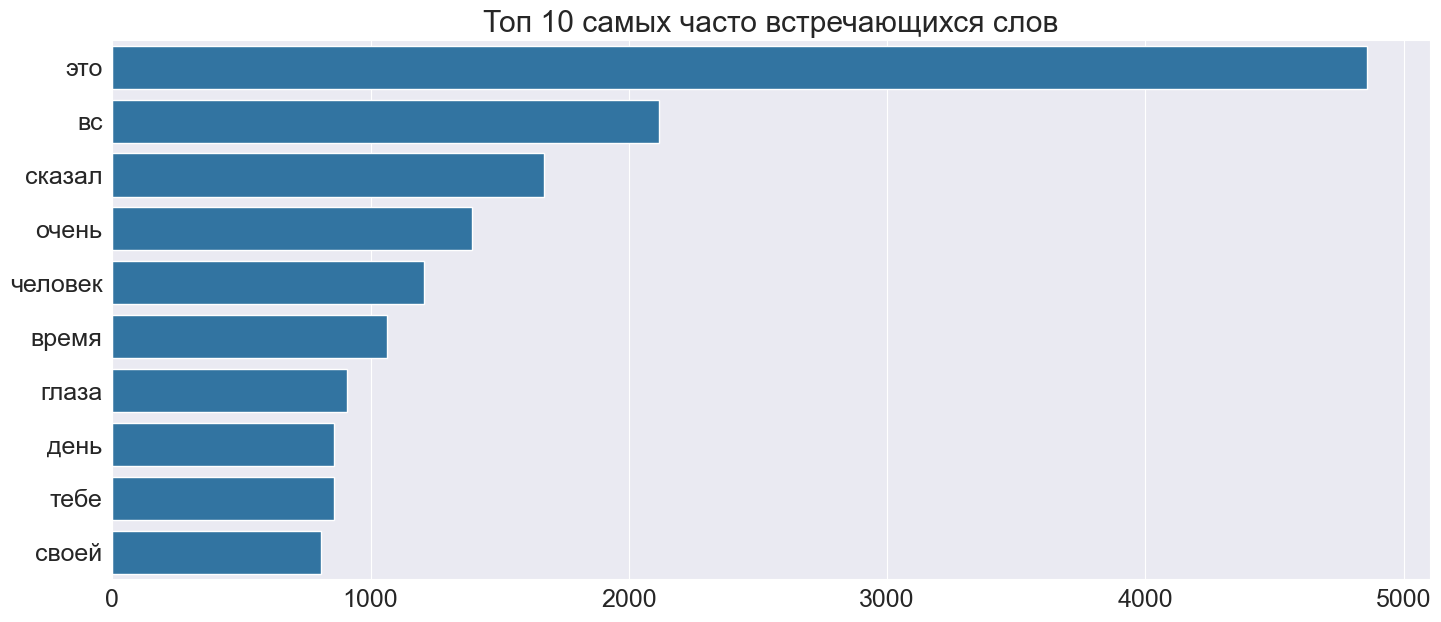

In [82]:
sns.barplot(x=freq, y=words)
plt.title('Топ 10 самых часто встречающихся слов')
plt.show()

In [83]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['text'])

In [84]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

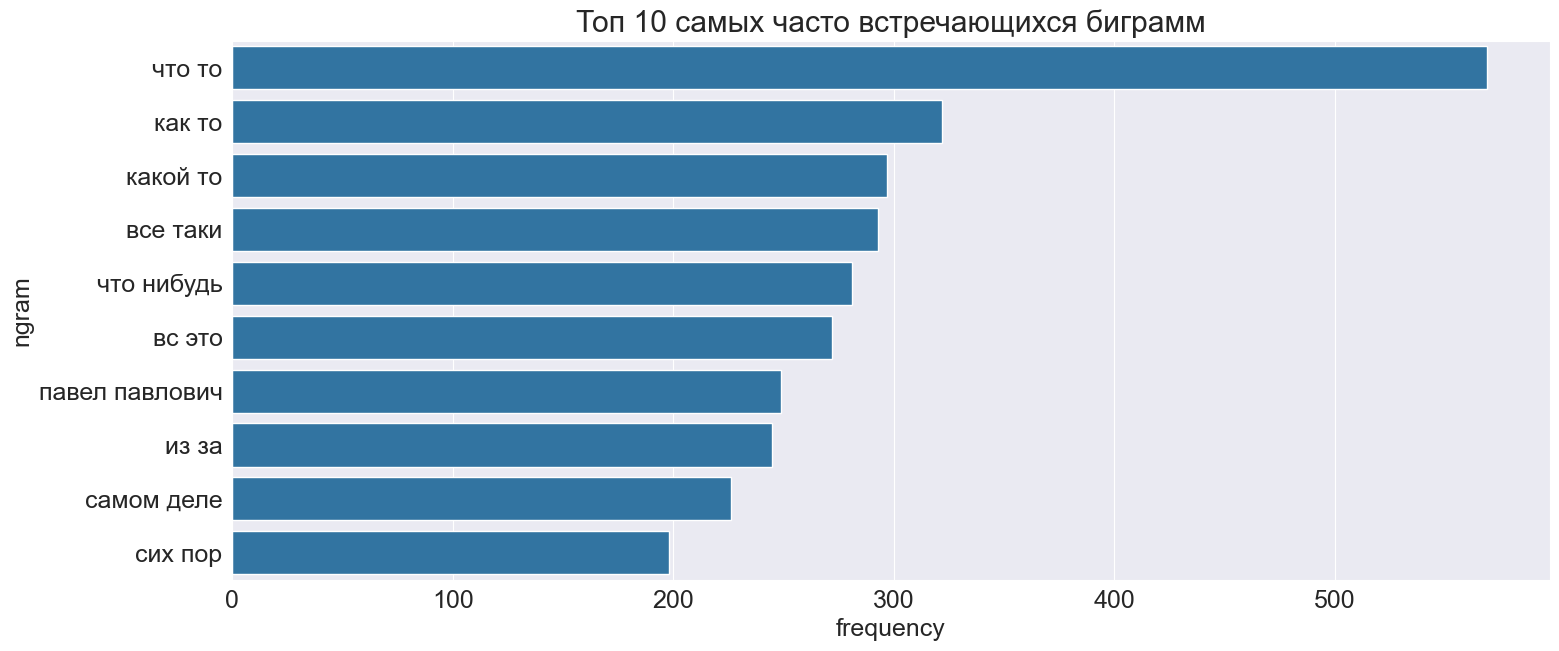

In [85]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Топ 10 самых часто встречающихся биграмм')
plt.show()

In [86]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['text'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

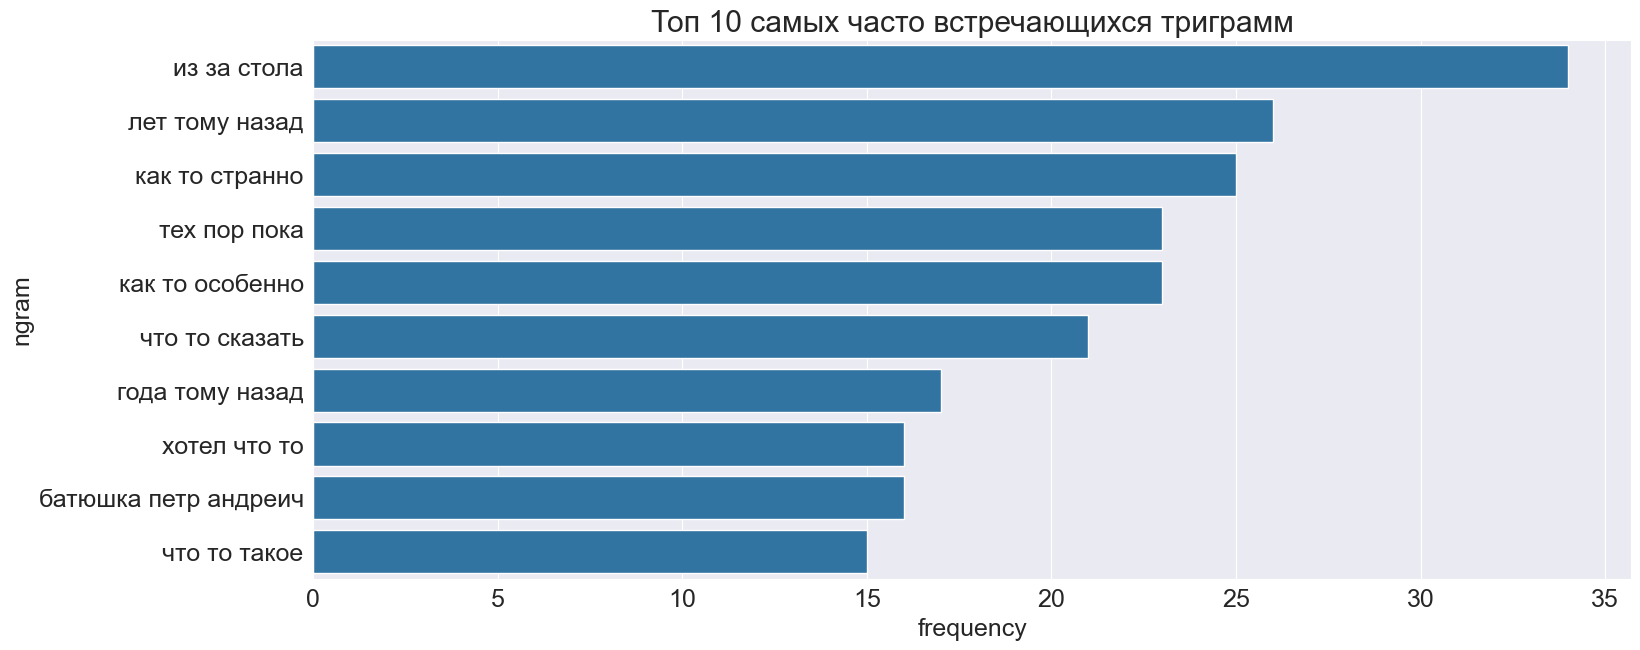

In [87]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Топ 10 самых часто встречающихся триграмм')
plt.show()

# Загружаем уже расспличенные тексты

In [6]:
BUCKET_NAME = "mlds23-authorship-identification"
BUCKET_DIR = "splitted_data/"
FILENAME = 'splitted_df.csv'
#загружает в локальную директорию, потом отдельно надо считывать
s3.download_file(Filename=FILENAME, Bucket=BUCKET_NAME, Key=BUCKET_DIR + FILENAME)

In [7]:
df = pd.read_csv('splitted_df.csv')

# извлекаем статистику

In [27]:
from ruts import BasicStats

- количество предложений
- количество слов
- количество уникальных слов
- количество длинных слов
- количество сложных слов
- количество простых слов
- количество односложных слов
- количество многосложных слов
- количество символов
- количество букв
- количество пробелов
- количество слогов
- количество знаков препинания

In [34]:
def bs(text):
    # Проверяем, что строка не пустая и содержит слова
    if not text.strip() or not re.search(r'\w', text):
        # Возвращаем пустой словарь, если условие не выполнено
        return {}
    bs = BasicStats(text)
    dct = bs.get_stats()
    del dct['c_letters']
    del dct['c_syllables']
    return dct

In [35]:
# Применяем функцию к колонке 'text' и создаем новые колонки
df_stats = pd.concat([df['text'].apply(bs).apply(pd.Series)], axis=1)
# Объединяем исходный датафрейм с новыми колонками
df = pd.concat([df, df_stats], axis=1)

             target                                               text  \
0      author_id_06  Узкими горными тропинками , от одного дачного ...   
1      author_id_06  свернутый ковер для акробатических упражнений ...   
2      author_id_06  позабытые . Кроме того , были в шарманке две п...   
3      author_id_06  тайной грусти : — Что поделаешь ? .. Древний о...   
4      author_id_06  , да уж ладно ! Кормила она нас с тобой , Серг...   
...             ...                                                ...   
11710  author_id_08  далеко до цели , видимой только по массе дыма ...   
11711  author_id_08  сомневайтесь , — отвечал молодой солдат с весе...   
11712  author_id_08  как зачали пули летать , бросил он и сумки и р...   
11713  author_id_08  воздухе действительно что-то зашуршало . Это б...   
11714  author_id_08  , раздался выстрел . Веселый солдат уткнулся л...   

                                             book  n_sents  n_words  \
0      raw_data/aleksandr_kuprin_belyj_p

In [36]:
df.head()

,target,text,book,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,n_polysyllable_words,n_chars,n_letters,n_spaces,n_syllables,n_punctuations
0,author_id_06,"Узкими горными тропинками , от одного дачного ...",raw_data/aleksandr_kuprin_belyj_pudel'.txt,5.0,66.0,64.0,44.0,14.0,52.0,12.0,54.0,522.0,428.0,79.0,180.0,15.0
1,author_id_06,свернутый ковер для акробатических упражнений ...,raw_data/aleksandr_kuprin_belyj_pudel'.txt,3.0,78.0,70.0,38.0,12.0,61.0,18.0,55.0,536.0,431.0,90.0,177.0,15.0
2,author_id_06,"позабытые . Кроме того , были в шарманке две п...",raw_data/aleksandr_kuprin_belyj_pudel'.txt,5.0,82.0,72.0,36.0,16.0,65.0,27.0,54.0,538.0,419.0,100.0,184.0,19.0
3,author_id_06,тайной грусти : — Что поделаешь ? .. Древний о...,raw_data/aleksandr_kuprin_belyj_pudel'.txt,8.0,73.0,68.0,34.0,8.0,63.0,17.0,54.0,546.0,387.0,109.0,160.0,50.0
4,author_id_06,", да уж ладно ! Кормила она нас с тобой , Серг...",raw_data/aleksandr_kuprin_belyj_pudel'.txt,4.0,78.0,74.0,35.0,8.0,66.0,22.0,52.0,540.0,419.0,97.0,166.0,24.0


## анализируем статистику по каждому автору

In [38]:
df.groupby('target')[['n_sents', 'n_words', 'n_unique_words',
       'n_long_words', 'n_complex_words', 'n_simple_words',
       'n_monosyllable_words', 'n_polysyllable_words', 'n_chars', 'n_letters',
       'n_spaces', 'n_syllables', 'n_punctuations']].mean()

,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,n_polysyllable_words,n_chars,n_letters,n_spaces,n_syllables,n_punctuations
target,,,,,,,,,,,,,
author_id_00,6.012317,77.305620,66.005389,35.224018,13.096998,60.035412,21.209392,51.923018,525.394149,405.712856,95.405697,173.242494,22.398768
author_id_01,7.669312,79.899471,67.952381,34.177249,8.828042,68.195767,23.312169,53.711640,528.111111,399.640212,99.865079,168.994709,28.539683
author_id_02,5.878788,78.385070,65.613082,33.884331,10.978197,63.701774,23.989283,50.690687,528.244272,397.286401,100.269032,168.120103,29.382114
author_id_03,5.697385,81.693649,67.376090,33.361146,10.764633,66.945205,24.889166,52.820672,528.775841,402.402242,100.971357,172.440847,25.017435
author_id_04,4.749035,78.907336,66.000000,33.873359,11.731274,63.847104,22.955985,52.622394,524.951351,406.049421,96.900386,172.599228,21.884170
author_id_05,4.805517,78.245517,66.195862,34.357241,11.044138,63.000000,21.351724,52.692414,524.998621,402.074483,97.921379,169.697931,24.742069
author_id_06,5.527221,76.465138,66.382999,35.851958,12.335244,60.789876,20.216810,52.908309,526.706781,408.099331,94.230181,172.696275,23.994269
author_id_07,4.849438,81.728090,67.406742,32.746067,9.386517,68.955056,24.011236,54.330337,524.743820,402.224719,98.892135,171.651685,23.586517
author_id_08,6.862620,82.317891,67.436102,32.571885,9.541534,69.503195,25.988818,53.055911,527.517572,399.651757,101.597444,171.153355,25.704473


In [40]:
df.groupby('target')[['n_sents', 'n_words', 'n_unique_words',
       'n_long_words', 'n_complex_words', 'n_simple_words',
       'n_monosyllable_words', 'n_polysyllable_words', 'n_chars', 'n_letters',
       'n_spaces', 'n_syllables', 'n_punctuations']].median()

,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,n_polysyllable_words,n_chars,n_letters,n_spaces,n_syllables,n_punctuations
target,,,,,,,,,,,,,
author_id_00,6.0,78.0,66.0,35.0,13.0,60.0,21.0,52.0,532.0,410.0,95.0,175.0,20.0
author_id_01,7.0,80.0,68.0,34.0,9.0,69.0,24.0,54.0,534.5,404.0,101.0,171.0,28.0
author_id_02,6.0,79.0,66.0,34.0,11.0,64.0,24.0,51.0,535.0,399.0,100.0,169.0,28.0
author_id_03,5.0,82.0,68.0,34.0,11.0,68.0,24.0,53.0,537.0,407.0,101.0,174.0,24.0
author_id_04,5.0,79.0,66.0,34.0,12.0,64.0,22.0,53.0,532.0,409.0,97.0,174.0,20.0
author_id_05,4.0,79.0,67.0,35.0,11.0,64.0,21.0,53.0,535.0,407.0,99.0,172.0,24.0
author_id_06,5.0,77.0,67.0,36.0,12.0,61.0,20.0,53.0,535.0,412.0,94.0,174.0,21.0
author_id_07,4.0,82.0,68.0,33.0,9.0,70.0,24.0,55.0,535.0,406.0,100.0,174.0,22.0
author_id_08,7.0,83.0,68.0,33.0,10.0,71.0,26.0,54.0,537.0,404.0,102.0,173.0,25.0
